# Modeling and Baseline Forecasting

![Milestone 3](https://s3.ap-southeast-1.amazonaws.com/www.jiahao.io/manning/project1_milestone3.png)

This part involves three parts:
1. Build baseline model using Naive and sNaive methods
2. Understand the various metrics for evaluation of time series model and decide on our metrics
3. Set up model using Facebook Prophet for comparison

## Importing Necessary Libraries and Functions

The data (data/sales_cleaned.csv) that we are using is an output from previous parts. 

Again, recall that challenge is to forecast the sales of the respective stores by each category for the next 28 days.

In [ ]:
RunningInCOLAB = 'google.colab' in str(get_ipython())

# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
if RunningInCOLAB:
  !pip install prophet
from prophet import Prophet
import itertools

%matplotlib inline

# suppress pandas SettingWithCopyWarning 
pd.options.mode.chained_assignment = None

## Building our Baseline Model

In order to know how well our models are performing, we need a baseline model for reference. The baseline model will use a very quick and simple method (in our case, Naive or sNaive method) and our models must have better performance than the baseline to be useful.

The Naive method uses the last known observation of the time series as forecasts for the next 28 days.

The Seasonal Naive (sNaive) method is similar to the Naive method, but this time the forecasts of the model are equal to the last known observation of the same seasonal period. In our case, we will set the period as 7 days based on our analysis in previous part.

<ins>Instructions</ins>:<br>
- Let's read in our sales_cleaned.csv data and paste our train-test split function from previous part.

In [2]:
if RunningInCOLAB:
  from google.colab import files

  uploaded = files.upload()

  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

Saving sales_cleaned.csv to sales_cleaned.csv
User uploaded file "sales_cleaned.csv" with length 2509831 bytes


In [3]:
# read in our processed data
# by using parse_dates in parameter of read_csv, we can convert date column to datetime format without additional step
if RunningInCOLAB:
  sales_df = pd.read_csv('./sales_cleaned.csv', parse_dates=['date'])
else:
  sales_df = pd.read_csv('../data/sales_cleaned.csv', parse_dates=['date'])  # use this if running notebook in local 
sales_df.info()
sales_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54384 entries, 0 to 54383
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   store_id   54384 non-null  object        
 1   cat_id     54384 non-null  object        
 2   date       54384 non-null  datetime64[ns]
 3   sales      54384 non-null  float64       
 4   series_id  54384 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 2.1+ MB


,store_id,cat_id,date,sales,series_id
0,TX_1,FOODS,2011-01-29,3950.35,TX_1_FOODS
1,TX_1,FOODS,2011-01-30,3844.97,TX_1_FOODS
2,TX_1,FOODS,2011-01-31,2888.03,TX_1_FOODS
3,TX_1,FOODS,2011-02-01,3631.28,TX_1_FOODS
4,TX_1,FOODS,2011-02-02,3072.18,TX_1_FOODS


In [4]:
def get_cv_split(df, split_num, prediction_length=28, validation=True):
    """
    Implement train-test split given a cv split number and return training, val and test data
    """
    if 'series_id' not in df.columns:
        df['series_id'] = df['store_id'] + '_' + df['cat_id']
    series_list = df['series_id'].unique()

    test_list = []
    validation_list = []
    training_list = []

    for series in series_list:
        df_series = df.loc[df.series_id==series]
        max_date = df_series.date.max()
        min_date = df_series.date.min()
        test_lower_date = max_date - pd.Timedelta(f"{prediction_length*((split_num+1)*2-1)} days")
        test_upper_date = max_date - pd.Timedelta(f"{prediction_length*(split_num*2)} days")
        val_lower_date = max_date - pd.Timedelta(f"{prediction_length*(split_num+1)*2} days")
        if min(test_lower_date, test_upper_date) < min_date:
            raise Exception("Insufficient data for splitting")

        df_series_test = df_series.loc[(df_series.date > test_lower_date) & (df_series.date <= test_upper_date)]
        if validation:
            df_series_val = df_series.loc[(df_series.date > val_lower_date) & (df_series.date <= test_lower_date)]
            df_series_train = df_series.loc[df_series.date <= val_lower_date]
        else:
            df_series_val = pd.DataFrame()
            df_series_train = df_series.loc[df_series.date <= test_lower_date]
        test_list.append(df_series_test)
        validation_list.append(df_series_val)
        training_list.append(df_series_train)

    test_df = pd.concat(test_list)
    validation_df = pd.concat(validation_list)
    training_df = pd.concat(training_list)
    return training_df, validation_df, test_df

<ins>Instructions</ins>:<br>
- Now let's start off with implementing the Naive method. Develop a function that will take in the training and test data and return a dataframe containing the test data and corresponding predictions.

In [5]:
def naive_predictions(training_df, test_df):
    """
    Implement the Naive method and return dataframe with test data and corresponding predictions
    """
    series_list = training_df['series_id'].unique()
    naive_pred_list = []
    for series in series_list:
        training_df_series = training_df.loc[training_df.series_id==series]
        last_obs_df = training_df_series.loc[training_df_series.date == training_df_series.date.max(), ['series_id','sales']]
        naive_pred_list.append(last_obs_df)
    naive_pred_df = pd.concat(naive_pred_list)
    naive_pred_df.rename(columns={'sales':'naive_pred'}, inplace=True)
    naive_test_df = test_df.merge(naive_pred_df, on='series_id', how='left')
    return naive_test_df

In [6]:
# Naive method for first cv split
training_df, _, test_df = get_cv_split(sales_df, 0, validation=False)
naive_test_df = naive_predictions(training_df, test_df)
naive_test_df.info()
naive_test_df.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 840 entries, 0 to 839
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   store_id    840 non-null    object        
 1   cat_id      840 non-null    object        
 2   date        840 non-null    datetime64[ns]
 3   sales       840 non-null    float64       
 4   series_id   840 non-null    object        
 5   naive_pred  840 non-null    float64       
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 45.9+ KB


,store_id,cat_id,date,sales,series_id,naive_pred
0,TX_1,FOODS,2016-04-25,5236.10,TX_1_FOODS,6627.53
1,TX_1,FOODS,2016-04-26,4632.85,TX_1_FOODS,6627.53
2,TX_1,FOODS,2016-04-27,4939.37,TX_1_FOODS,6627.53


Let's plot our Naive predictions against real data for visualization.

<ins>Instructions</ins>:<br>
- For a given time series, plot the Naive predictions against actual sales

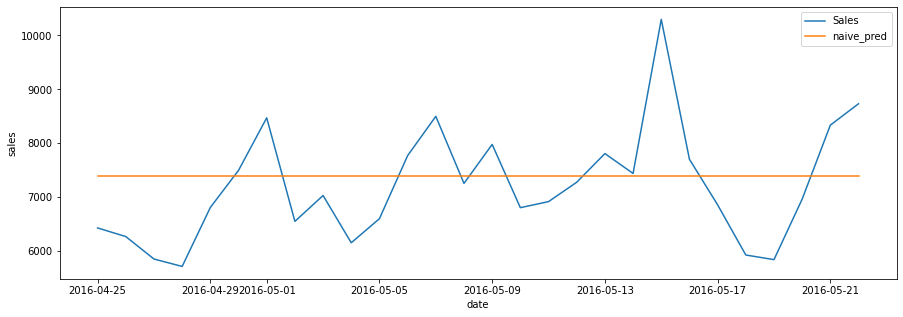

In [7]:
def plot_pred(prediction_test_df, series_id, yhat):
    """
    Plot the predictions against actual sales for a specified time series
    """
    prediction_test_df_series = prediction_test_df.loc[prediction_test_df.series_id==series_id]
    plt.figure(figsize=(15,5))
    sns.lineplot(x=prediction_test_df_series.date, y=prediction_test_df_series.sales, label='Sales')
    sns.lineplot(x=prediction_test_df_series.date, y=prediction_test_df_series[yhat], label=yhat)

plot_pred(naive_test_df, 'TX_2_FOODS', 'naive_pred')

From our plot, we can see that the Naive predictions are uninteresting; just a horizontal straight line of constant value. Well, it's naive after all.

Now, let's implement the sNaive method. Remember, the seasonal period for our case is 7 days.

<ins>Instructions</ins>:<br>
- Implement the sNaive method using the last 7 known observations of each time series. Develop a function that will take in the training and test data and return a dataframe containing the test data and corresponding predictions.

In [8]:
def snaive_predictions(training_df, test_df):
    """
    Implement the sNaive method and return dataframe with test data and corresponding predictions
    """
    training_df['dayofweek'] = training_df['date'].dt.weekday
    series_list = training_df['series_id'].unique()
    snaive_pred_list = []
    for series in series_list:
        training_df_series = training_df.loc[training_df.series_id==series]
        training_df_series.sort_values(by='date', ascending=False, inplace=True)
        last_week_df = training_df_series[:7][['dayofweek', 'series_id','sales']]
        snaive_pred_list.append(last_week_df)
    snaive_pred_df = pd.concat(snaive_pred_list)
    snaive_pred_df.rename(columns={'sales':'snaive_pred'}, inplace=True)
    test_df['dayofweek'] = test_df['date'].dt.weekday
    snaive_test_df = test_df.merge(snaive_pred_df, on=['series_id', 'dayofweek'], how='left')
    return snaive_test_df

In [9]:
# sNaive predictions for first cv split
training_df, _, test_df = get_cv_split(sales_df, 0, validation=False)
snaive_test_df = snaive_predictions(training_df, test_df)
snaive_test_df.info()
snaive_test_df.head(10)     

<class 'pandas.core.frame.DataFrame'>
Int64Index: 840 entries, 0 to 839
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   store_id     840 non-null    object        
 1   cat_id       840 non-null    object        
 2   date         840 non-null    datetime64[ns]
 3   sales        840 non-null    float64       
 4   series_id    840 non-null    object        
 5   dayofweek    840 non-null    int64         
 6   snaive_pred  840 non-null    float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 52.5+ KB


,store_id,cat_id,date,sales,series_id,dayofweek,snaive_pred
0,TX_1,FOODS,2016-04-25,5236.10,TX_1_FOODS,0,6391.68
1,TX_1,FOODS,2016-04-26,4632.85,TX_1_FOODS,1,5701.26
2,TX_1,FOODS,2016-04-27,4939.37,TX_1_FOODS,2,4727.66
3,TX_1,FOODS,2016-04-28,3997.22,TX_1_FOODS,3,4510.38
4,TX_1,FOODS,2016-04-29,6013.73,TX_1_FOODS,4,5026.10
5,TX_1,FOODS,2016-04-30,6552.24,TX_1_FOODS,5,5947.91
6,TX_1,FOODS,2016-05-01,7121.82,TX_1_FOODS,6,6627.53
7,TX_1,FOODS,2016-05-02,4759.49,TX_1_FOODS,0,6391.68
8,TX_1,FOODS,2016-05-03,5467.08,TX_1_FOODS,1,5701.26
9,TX_1,FOODS,2016-05-04,4911.75,TX_1_FOODS,2,4727.66


Similarly, let's plot our sNaive predictions against the actual sales for a random time series.

<ins>Instructions</ins>:<br>
- Plot the sNaive predictions against the actual sales for a time series

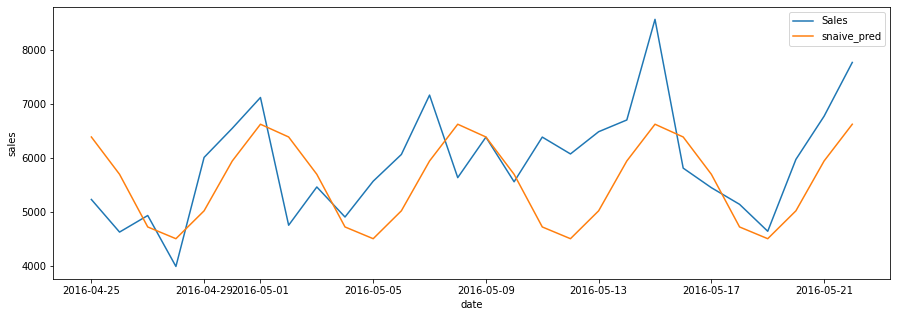

In [10]:
plot_pred(snaive_test_df, 'TX_1_FOODS', 'snaive_pred')

This time round, the sNaive predictions seem much more realistic and is somehow able to follow the oscillations of the actual sales.

Intuitively, we know that the sNaive method will be a better baseline than the Naive method. But rather than seeing random plots comparing the predictions against actual sales, is there a score that we can use to summarise the model performance?

This is what we shall set out to do in the next section below.

## Choosing our Metrics

In time series, there are various metrics that we can use to evaluate our models.

Based on Prof Rob Hyndman in this [paper](https://robjhyndman.com/papers/foresight.pdf), there are four types of metrics for time series forecasting. In our case, we shall compute Mean Absolute Error (MAE) and Mean Absolute Percentage Error (MAPE) for each time series.

In addition, because we have multiple time series, we need to somehow weigh the score for each time series and combine them into a single overall score. In our case, we shall weigh the time series based on the cumulative actual dollar sales, which is computed using the last 28 observations of the training data. This weightage method follows the [M5 competition in Kaggle](https://www.kaggle.com/c/m5-forecasting-accuracy/overview/evaluation). 

<ins>Instructions</ins>:<br>
- Implement a function that given a time series, computes the MAE
- Implement a function that given a training and test data, computes the weighted MAE
- Implement code to calculate the cross-validated weighted MAE for the Naive and sNaive models respectively. Use 3 splits.

In [11]:
def compute_mae(training_df, prediction_test_df, y, y_hat, series_id):
    """
    Given a time series ID, compute the MAE for that time series and return the last 28-day training sales
    """
    prediction_test_df_series = prediction_test_df.loc[prediction_test_df.series_id==series_id]
    training_df_series = training_df.loc[training_df.series_id==series_id]
    training_df_series.sort_values(by='date', ascending=False, inplace=True)
    prediction_test_df_series['abs_error'] = (prediction_test_df_series[y_hat] - prediction_test_df_series[y]).abs()
    mae = prediction_test_df_series['abs_error'].mean()
    total_sales = training_df_series[:28]['sales'].sum()
    return mae, total_sales

def compute_wmae(training_df, prediction_test_df, y, y_hat):
    """
    Given a training and prediction data, compute the weighted MAE
    """
    series_list = prediction_test_df.series_id.unique()
    sales_list = []
    mae_list = []
    for series in series_list:
        mae_series, total_sales_series = compute_mae(training_df, prediction_test_df, y, y_hat, series)
        mae_list.append(mae_series)
        sales_list.append(total_sales_series)
    overall_sales = np.sum(sales_list)
    weights_list = [s/overall_sales for s in sales_list]
    wmae_list = [a*b for a,b in zip(mae_list, weights_list)]
    wmae = np.sum(wmae_list)
    return wmae


In [12]:
# computes the cross-validated weighted MAE for the Naive model
wmae_list = []
cv = 3
for i in range(cv):
    training_df, _, test_df = get_cv_split(sales_df, i, validation=False)
    naive_test_df = naive_predictions(training_df, test_df)
    wmae = compute_wmae(training_df, naive_test_df, 'sales', 'naive_pred')
    wmae_list.append(wmae)
print(f"The weighted MAE for each of the CV splits is : {wmae_list}")
print(f"The cross-validated weighted MAE is {np.mean(wmae_list)}")

The weighted MAE for each of the CV splits is : [1549.1222546964927, 1654.8051652251672, 1369.5453562984808]
The cross-validated weighted MAE is 1524.4909254067134


In [13]:
# computes the cross-validated weighted MAE for the sNaive model
wmae_list = []
cv = 3
for i in range(cv):
    training_df, _, test_df = get_cv_split(sales_df, i, validation=False)
    snaive_test_df = snaive_predictions(training_df, test_df)
    wmae = compute_wmae(training_df, snaive_test_df, 'sales', 'snaive_pred')
    wmae_list.append(wmae)
print(f"The weighted MAE for each of the CV splits is : {wmae_list}")
print(f"The cross-validated weighted MAE is {np.mean(wmae_list)}")

The weighted MAE for each of the CV splits is : [746.9086859014316, 775.20131732263, 994.348306673857]
The cross-validated weighted MAE is 838.8194366326394


Based on the 3-split cross-validated weighted MAE, the sNaive method has almost half the weighted MAE of the Naive method.

<ins>Instructions</ins>:<br>
Similar to the computation for MAE, we shall now implement the same for MAPE
- Implement a function that given a time series, computes the MAPE
- Implement a function that given a training and test data, computes the weighted MAPE
- Implement code to calculate the cross-validated weighted MAPE for the Naive and sNaive models respectively. Use 3 splits.

In [14]:
def compute_mape(training_df, prediction_test_df, y, y_hat, series_id):
    """
    Given a time series ID, compute the MAPE for that time series and return the last 28-day training sales
    """
    training_df_series = training_df.loc[training_df.series_id==series_id]
    training_df_series.sort_values(by='date', ascending=False, inplace=True)
    prediction_test_df_series = prediction_test_df.loc[prediction_test_df.series_id==series_id]
    prediction_test_df_series['abs_pct_error'] = ((prediction_test_df_series[y] - prediction_test_df_series[y_hat])/prediction_test_df_series[y]).abs()
    mape = prediction_test_df_series['abs_pct_error'].mean()
    total_sales = training_df_series[:28]['sales'].sum()
    return mape, total_sales

def compute_wmape(training_df, prediction_test_df, y, y_hat):
    """
    Given a training and prediction data, compute the weighted MAPE
    """
    series_list = prediction_test_df.series_id.unique()
    sales_list = []
    mape_list = []
    for series in series_list:
        mape_series, total_sales_series = compute_mape(training_df, prediction_test_df, y, y_hat, series)
        mape_list.append(mape_series)
        sales_list.append(total_sales_series)
    overall_sales = np.sum(sales_list)
    weights_list = [s/overall_sales for s in sales_list]
    wmape_list = [a*b for a,b in zip(mape_list, weights_list)]
    wmape = np.sum(wmape_list)
    return wmape

In [15]:
# computes the cross-validated weighted MAPE for the Naive model
wmape_list = []
cv = 3
for i in range(cv):
    training_df, _, test_df = get_cv_split(sales_df, i, validation=False)
    naive_test_df = naive_predictions(training_df, test_df)
    mape = compute_wmape(training_df, naive_test_df, 'sales', 'naive_pred')
    wmape_list.append(mape)
print(f"The weighted MAPE for each of the CV splits is : {wmape_list}")
print(f"The cross-validated weighted MAPE is {np.mean(wmape_list)}")

The weighted MAPE for each of the CV splits is : [0.26802494735938304, 0.33430773166159955, 0.28459156674376745]
The cross-validated weighted MAPE is 0.2956414152549167


In [16]:
# computes the cross-validated weighted MAPE for the sNaive model
wmape_list = []
cv = 3
for i in range(cv):
    training_df, _, test_df = get_cv_split(sales_df, i, validation=False)
    snaive_test_df = snaive_predictions(training_df, test_df)
    mape = compute_wmape(training_df, snaive_test_df, 'sales', 'snaive_pred')
    wmape_list.append(mape)
print(f"The weighted MAPE for each of the CV splits is : {wmape_list}")
print(f"The cross-validated weighted MAPE is {np.mean(wmape_list)}")

The weighted MAPE for each of the CV splits is : [0.11080820228897773, 0.12949223332186904, 0.18557500839828184]
The cross-validated weighted MAPE is 0.1419584813363762


Similar to the conclusions from analysing the MAE, the sNaive model has a lower weighted MAPE than the Naive model. 

We will therefore use the sNaive method as our baseline.

## Forecasting with Facebook Prophet

Now that we have a baseline reference, let's implement a more sophisticated model for our forecasting.

[Facebook Prophet](https://facebook.github.io/prophet/) is an open source software released by Facebook and is used in many applications across Facebook for producing reliable forecasts.

We shall use Prophet to implement our model.

<ins>Instructions</ins>:<br>
- Implement a model using Prophet to forecast the next 28 days sales for each time series
- Test your model using the first CV split
- Plot the Prophet predictions against the actual sales

In [17]:
def prophet_predictions(training_df, test_df, cv, monthly_seasonality=True, changepoint_prior_scale=0.05, changepoint_range=0.8):
    """
    Train and predict sales using Prophet
    """
    training_df.rename(columns={'sales': 'y', 'date':'ds'}, inplace=True)
    series_list = training_df['series_id'].unique()
    prophet_pred_list = []
    for series in tqdm(series_list, desc=f"Predicting for cv{cv}:"):
        training_df_series = training_df.loc[training_df.series_id==series]
        m = Prophet(yearly_seasonality=False, daily_seasonality=False, 
                    changepoint_prior_scale=changepoint_prior_scale, changepoint_range=changepoint_range)
        if monthly_seasonality:
            # add monthly seasonality to model
            m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
        m.fit(training_df_series)
        future = m.make_future_dataframe(periods=28, include_history=False)
        forecast = m.predict(future)[['ds', 'yhat']]
        forecast['series_id'] = series
        prophet_pred_list.append(forecast)
    prophet_pred_df = pd.concat(prophet_pred_list)
    prophet_pred_df.rename(columns={'ds':'date', 'yhat':'prophet_pred'}, inplace=True)
    prophet_test_df = test_df.merge(prophet_pred_df, on=['series_id', 'date'], how='left')
    training_df.rename(columns={'ds': 'date', 'y': 'sales'}, inplace=True)
    return prophet_test_df

In [18]:
# Run Prophet model for first CV split
cv = 0
training_df, validation_df, test_df = get_cv_split(sales_df, cv, validation=True)
prophet_test_df = prophet_predictions(training_df, validation_df, cv)
prophet_test_df.info()
prophet_test_df.head(3)

Predicting for cv0:: 100%|██████████| 30/30 [00:57<00:00,  1.93s/it]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 840 entries, 0 to 839
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   store_id      840 non-null    object        
 1   cat_id        840 non-null    object        
 2   date          840 non-null    datetime64[ns]
 3   sales         840 non-null    float64       
 4   series_id     840 non-null    object        
 5   prophet_pred  840 non-null    float64       
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 45.9+ KB


,store_id,cat_id,date,sales,series_id,prophet_pred
0,TX_1,FOODS,2016-03-28,4761.47,TX_1_FOODS,4406.284253
1,TX_1,FOODS,2016-03-29,3878.09,TX_1_FOODS,3955.109517
2,TX_1,FOODS,2016-03-30,4161.50,TX_1_FOODS,3878.818647


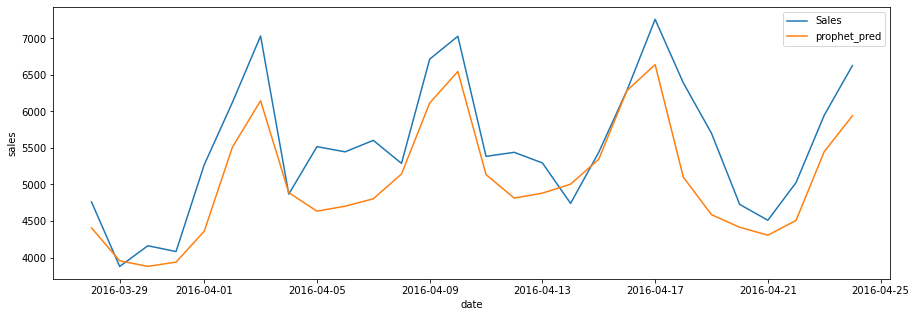

In [19]:
# plot Prophet predictions against actual sales
plot_pred(prophet_test_df, 'TX_1_FOODS', 'prophet_pred')

There are some key [hyperparameters](https://facebook.github.io/prophet/docs/trend_changepoints.html#automatic-changepoint-detection-in-prophet) of the Prophet model that we can tune. In our case, we shall experiment with 2 key hyperparameters:
1. changepoint_range
2. changepoint_prior_scale

Recall the nested walk-forward validation strategy where we will use the validation set to determine our optimal hyperparameters first before fitting the model on both the training and validation set to evaluate on test data.

![Walk Forward Validation](https://s3.ap-southeast-1.amazonaws.com/www.jiahao.io/manning/walk_forward_validation.png)

<ins>Instructions</ins>:<br>
- Setup a function to implement grid search that will return the optimal hyperparameters and the corresponding weighted MAE score. For our hyperparameters, we shall use 
'changepoint_range': [0.8, 0.9] and
'changepoint_prior_scale': [0.05, 0.1, 0.3].

In [21]:
def grid_search_prophet(cv=3):
    """
    Implement grid search with the Prophet model and return optimal hyperparameters and weighted MAE
    """
    param_grid = {  
    'changepoint_range': [0.8, 0.9],
    'changepoint_prior_scale': [0.05, 0.1, 0.3],
    }
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    
    best_result = np.inf
    best_params = None

    for param_set in all_params:
        print(f"Evaluating {param_set}...")
        wmae_list = []
        for i in range(cv):
            training_df, validation_df, _ = get_cv_split(sales_df, i, validation=True)
            prophet_eval_df = prophet_predictions(training_df, validation_df, i, **param_set)
            wmae = compute_wmae(training_df, prophet_eval_df, 'sales', 'prophet_pred')
            wmae_list.append(wmae)
        overall_wmae = np.mean(wmae_list)
        print(f"Weighted MAE for parameters {param_set} is: {overall_wmae}")
        if overall_wmae < best_result:
            best_params = param_set
            best_result = overall_wmae
    print(f"Best eval result: {best_result} with parameters {best_params}")
    return best_result, best_params

In [22]:
best_result, best_params = grid_search_prophet()

Evaluating {'changepoint_range': 0.8, 'changepoint_prior_scale': 0.05}...


Predicting for cv2:: 100%|██████████| 30/30 [00:56<00:00,  1.87s/it]


Weighted MAE for parameters {'changepoint_range': 0.8, 'changepoint_prior_scale': 0.05} is: 623.4757419292526
Evaluating {'changepoint_range': 0.8, 'changepoint_prior_scale': 0.1}...


Predicting for cv2:: 100%|██████████| 30/30 [01:00<00:00,  2.02s/it]


Weighted MAE for parameters {'changepoint_range': 0.8, 'changepoint_prior_scale': 0.1} is: 619.4527582793328
Evaluating {'changepoint_range': 0.8, 'changepoint_prior_scale': 0.3}...


Predicting for cv2:: 100%|██████████| 30/30 [01:11<00:00,  2.37s/it]


Weighted MAE for parameters {'changepoint_range': 0.8, 'changepoint_prior_scale': 0.3} is: 622.6037148004352
Evaluating {'changepoint_range': 0.9, 'changepoint_prior_scale': 0.05}...


Predicting for cv2:: 100%|██████████| 30/30 [00:55<00:00,  1.85s/it]


Weighted MAE for parameters {'changepoint_range': 0.9, 'changepoint_prior_scale': 0.05} is: 626.2184251616424
Evaluating {'changepoint_range': 0.9, 'changepoint_prior_scale': 0.1}...


Predicting for cv2:: 100%|██████████| 30/30 [01:01<00:00,  2.05s/it]


Weighted MAE for parameters {'changepoint_range': 0.9, 'changepoint_prior_scale': 0.1} is: 619.4130382946547
Evaluating {'changepoint_range': 0.9, 'changepoint_prior_scale': 0.3}...


Predicting for cv2:: 100%|██████████| 30/30 [01:12<00:00,  2.43s/it]

Weighted MAE for parameters {'changepoint_range': 0.9, 'changepoint_prior_scale': 0.3} is: 625.7748327489066
Best eval result: 619.4130382946547 with parameters {'changepoint_range': 0.9, 'changepoint_prior_scale': 0.1}


Great, now we have our optimal hyperparameters. For our last step, we shall evaluate our Prophet model with the optimal hyperparameters. Needless to say, our Prophet model should be better than the sNaive model.

Ps: After all the evaluations are done, remember to set predictions on Christmas to 0.

<ins>Instructions</ins>:<br>
- Compute the 3-split cross-validated weighted MAE and weighted MAPE on the test data
- Compare your results against the sNaive baseline results

In [23]:
# compute weight MAE for Prophet predictions
wmae_list = []
cv = 3
for i in range(cv):
    training_df, _, test_df = get_cv_split(sales_df, i, validation=False)
    prophet_test_df = prophet_predictions(training_df, test_df, i, **best_params)
    wmae = compute_wmae(training_df, prophet_test_df, 'sales', 'prophet_pred')
    wmae_list.append(wmae)
print(f"The weighted MAE for each of the CV splits is : {wmae_list}")
print(f"The cross-validated weighted MAE is {np.mean(wmae_list)}")

Predicting for cv2:: 100%|██████████| 30/30 [00:59<00:00,  1.99s/it]

The weighted MAE for each of the CV splits is : [659.9370161412803, 614.2685945627127, 533.0913460579925]
The cross-validated weighted MAE is 602.4323189206618


In [24]:
# compute weight MAPE for Prophet predictions
wmape_list = []
cv = 3
for i in range(cv):
    training_df, _, test_df = get_cv_split(sales_df, i, validation=False)
    prophet_test_df = prophet_predictions(training_df, test_df, i, **best_params)
    wmape = compute_wmape(training_df, prophet_test_df, 'sales', 'prophet_pred')
    wmape_list.append(wmape)
print(f"The weighted MAPE for each of the CV splits is : {wmape_list}")
print(f"The cross-validated weighted MAPE is {np.mean(wmape_list)}")

Predicting for cv2:: 100%|██████████| 30/30 [00:59<00:00,  1.99s/it]

The weighted MAPE for each of the CV splits is : [0.09923975408961833, 0.10788393047350893, 0.10227516373854928]
The cross-validated weighted MAPE is 0.10313294943389217


## Conclusion

From part 1 to 3, we:
- Processed and cleaned a time series data
- Analysed time series and determine seasonality
- Implemented train-test split on time series data using nested walk-forward validation
- Established baseline models and optimize Prophet model
- Evaluated various models using weighted MAE and MAPE